## DISCOVERING CUSTOMER BEHAVIORAL PATTERNS

### 1) Project Topic
#### 1A) What is the project about? Which type of problem?

This project focuses on applying unsupervised machine learning techniques to analyze and segment customers in a marketing campaign dataset. The primary goal is to identify hidden patterns or groups of customers based on their behavioral and demographic characteristics, without using the target label during training.

The problem is an application of unsupervised learning, using Clustering methods such as PCA (for dimensionality reduction), KMeans, and Agglomerative Clustering to discover natural groupings within the data. After forming clusters, the project also evaluates how well the unsupervised models can be used to predict the target labels and compares their performance to a supervised learning model.

#### 1B) Goal and Motivation

The goal of this project is to uncover meaningful customer segments within a real-world marketing campaign dataset using unsupervised learning techniques. By identifying distinct groups of customers based on their demographic profiles, purchasing behavior, and engagement patterns, the project aim to provide insights that could support more effective marketing strategies.

Understanding customer heterogeneity is essential in targeted marketing. Different customers respond differently to promotions, spend in different categories, and exhibit diverse purchasing habits. Therefore, unsupervised learning offers a way to discover structure hidden in the data without relying on predefined categories. This project is motivated by the practical value of customer segmentation in business: to help identify groups such as high spenders, discount-driven customers, or low-engagement customers.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### 2) Data
#### 2A) Source, Description, and Citation
This dataset was obtained from Kaggle, a public repository of datasets shared by researchers and practitioners. Each column captures a distinct characteristic of the customer, including total spending, income and engagement patterns nand other demographic characteristics.  Each row represents the complete set of information for a single customer.

Akash Patel (2021). Customer Personality Analysis[marketing_campaign.csv].Kaggle

https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

In [25]:
data_path='data/marketing_campaign.csv'
df=pd.read_csv(data_path, sep='\t')
print(df.shape)
df.head()
df.info()

(2240, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 n

#### 2B) Data Description
The dataset contains 2240 rows and 29 columns with 28 features ( 24 numeric features, 3 categorical features and 1 date feature). 

Here are some of the most important features used in this project:
- Income: Annual household income of the customer
- Customer_Tenure: Number of days since the customer joined the program
- MntWines, MntMeatProducts, MntFishProducts: Amount spent in the last two years on different product categories
- NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases: Counts of purchases through various channels
- Kidhome / Teenhome: Number of children or teenagers in the household
- Response (target variable): Whether the customer accepted the last marketing offer (0 or 1)

### 3) Data cleaning
Cleaning goals:
- Missing values: Income => impute with median.
- Remove outliers in numeric features.
- Fix types
- Drop useless columns
- Create a few meaningful features

#### 3.1) Handle missing values

In [26]:
print("\nMissing values per column:")
display(df.isna().sum())


Missing values per column:


ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [27]:
 # Handle missing Income (24 rows) – impute with median
income_median = df["Income"].median()
df["Income"] = df["Income"].fillna(income_median)

In [28]:
# Check missing values after
print("\nMissing values AFTER imputation:")
print(df.isna().sum())


Missing values AFTER imputation:
ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64


#### 3.2) Fix types

In [29]:
# Parse date and create Age & Customer_Tenure
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format="%d-%m-%Y")
# Assume data collected in 2014
df["Age"] = 2014 - df["Year_Birth"]
df["Customer_Tenure"] = (pd.to_datetime("2014-01-01") - df["Dt_Customer"]).dt.days

#### 3.3) Removing outliers

In [30]:
# Drop extreme Income outlier
df = df[df["Income"] < 200000].copy()

#### 3.4) Drop useless columns

In [31]:
# Drop columns that are IDs or constant
cols_to_drop = ["ID", "Dt_Customer", "Z_CostContact", "Z_Revenue"]
df = df.drop(columns=cols_to_drop)

#### 3.5) Create a few meaning features

In [32]:
# Create total spend and total purchases
spend_cols = ["MntWines","MntFruits","MntMeatProducts","MntFishProducts",
              "MntSweetProducts","MntGoldProds"]
df["Total_Spend"] = df[spend_cols].sum(axis=1)

purchase_cols = ["NumDealsPurchases","NumWebPurchases","NumCatalogPurchases","NumStorePurchases"]
df["Total_Purchases"] = df[purchase_cols].sum(axis=1)

df.describe(include="all").transpose().head(15)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Year_Birth,2239.0,NaN,NaN,NaN,1968.802144,11.985494,1893.0,1959.0,1970.0,1977.0,1996.0
Education,2239,5,Graduation,1126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,2239,8,Married,864,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income,2239.0,NaN,NaN,NaN,51963.554712,21410.672116,1730.0,35533.5,51381.5,68277.5,162397.0
Kidhome,2239.0,NaN,NaN,NaN,0.443948,0.53839,0.0,0.0,0.0,1.0,2.0
Teenhome,2239.0,NaN,NaN,NaN,0.506476,0.544555,0.0,0.0,0.0,1.0,2.0
Recency,2239.0,NaN,NaN,NaN,49.121036,28.963662,0.0,24.0,49.0,74.0,99.0
MntWines,2239.0,NaN,NaN,NaN,304.067441,336.61483,0.0,24.0,174.0,504.5,1493.0
MntFruits,2239.0,NaN,NaN,NaN,26.307727,39.781468,0.0,1.0,8.0,33.0,199.0
MntMeatProducts,2239.0,NaN,NaN,NaN,167.016525,225.743829,0.0,16.0,67.0,232.0,1725.0


 ### 4) EDA-Inspect, Visualize, Analysis and Conclusion
The goal of the exploratory data analysis is to understand the overall structure of the marketing campaign dataset before applying unsupervised learning models. In particular, I want to inspect the distribution of key numerical variables such as income, age, recency, and total spending, explore relationships between features and the campaign response variable, identify correlations and possible multicollinearity among features, which motivates the use of PCA and careful feature scaling. To achieve this, I combine simple visualizations (histograms, boxplots, bar charts) with a correlation matrix and preliminary feature importance analysis.

#### 4A) Inspect and visualization

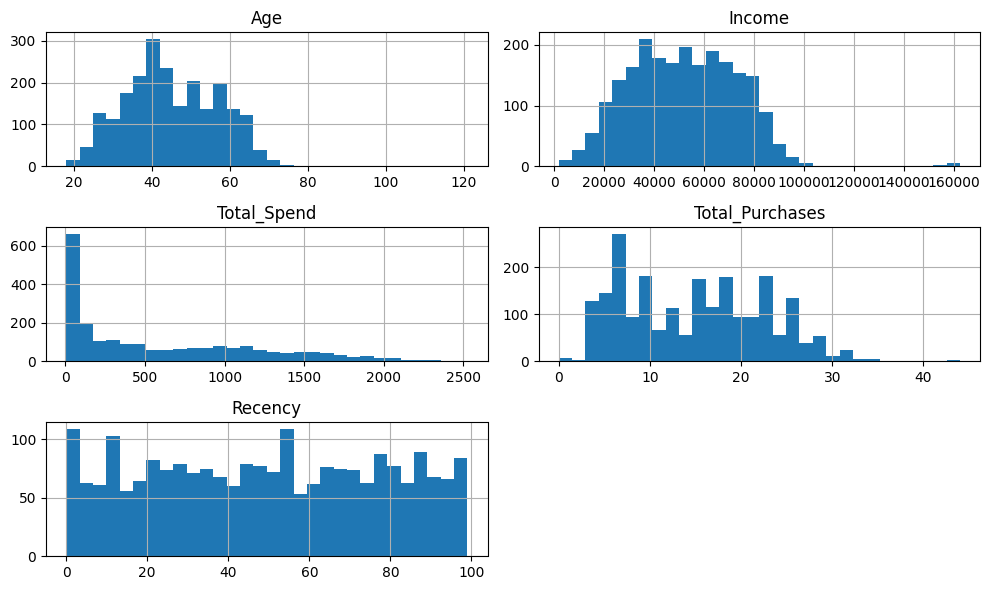

In [33]:
# Distribution of key numeric variables
num_cols_plot = ["Age","Income","Total_Spend","Total_Purchases","Recency"]
df[num_cols_plot].hist(bins=30, figsize=(10,6))
plt.tight_layout()
plt.show()


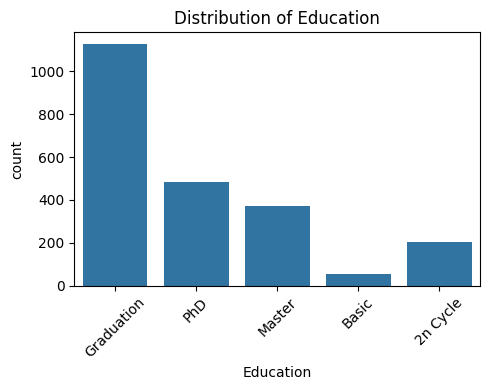

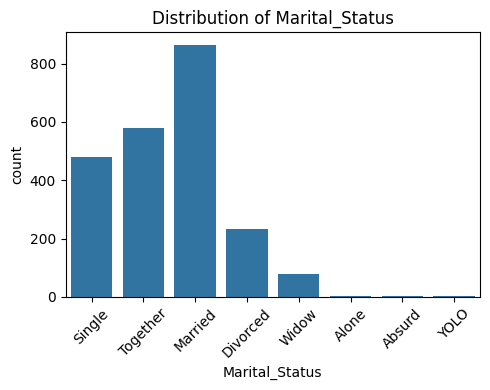

In [35]:
# Create bar plots for categorical variables
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
for col in cat_cols:
    plt.figure(figsize=(5,4))
    sns.countplot(x=df[col])
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

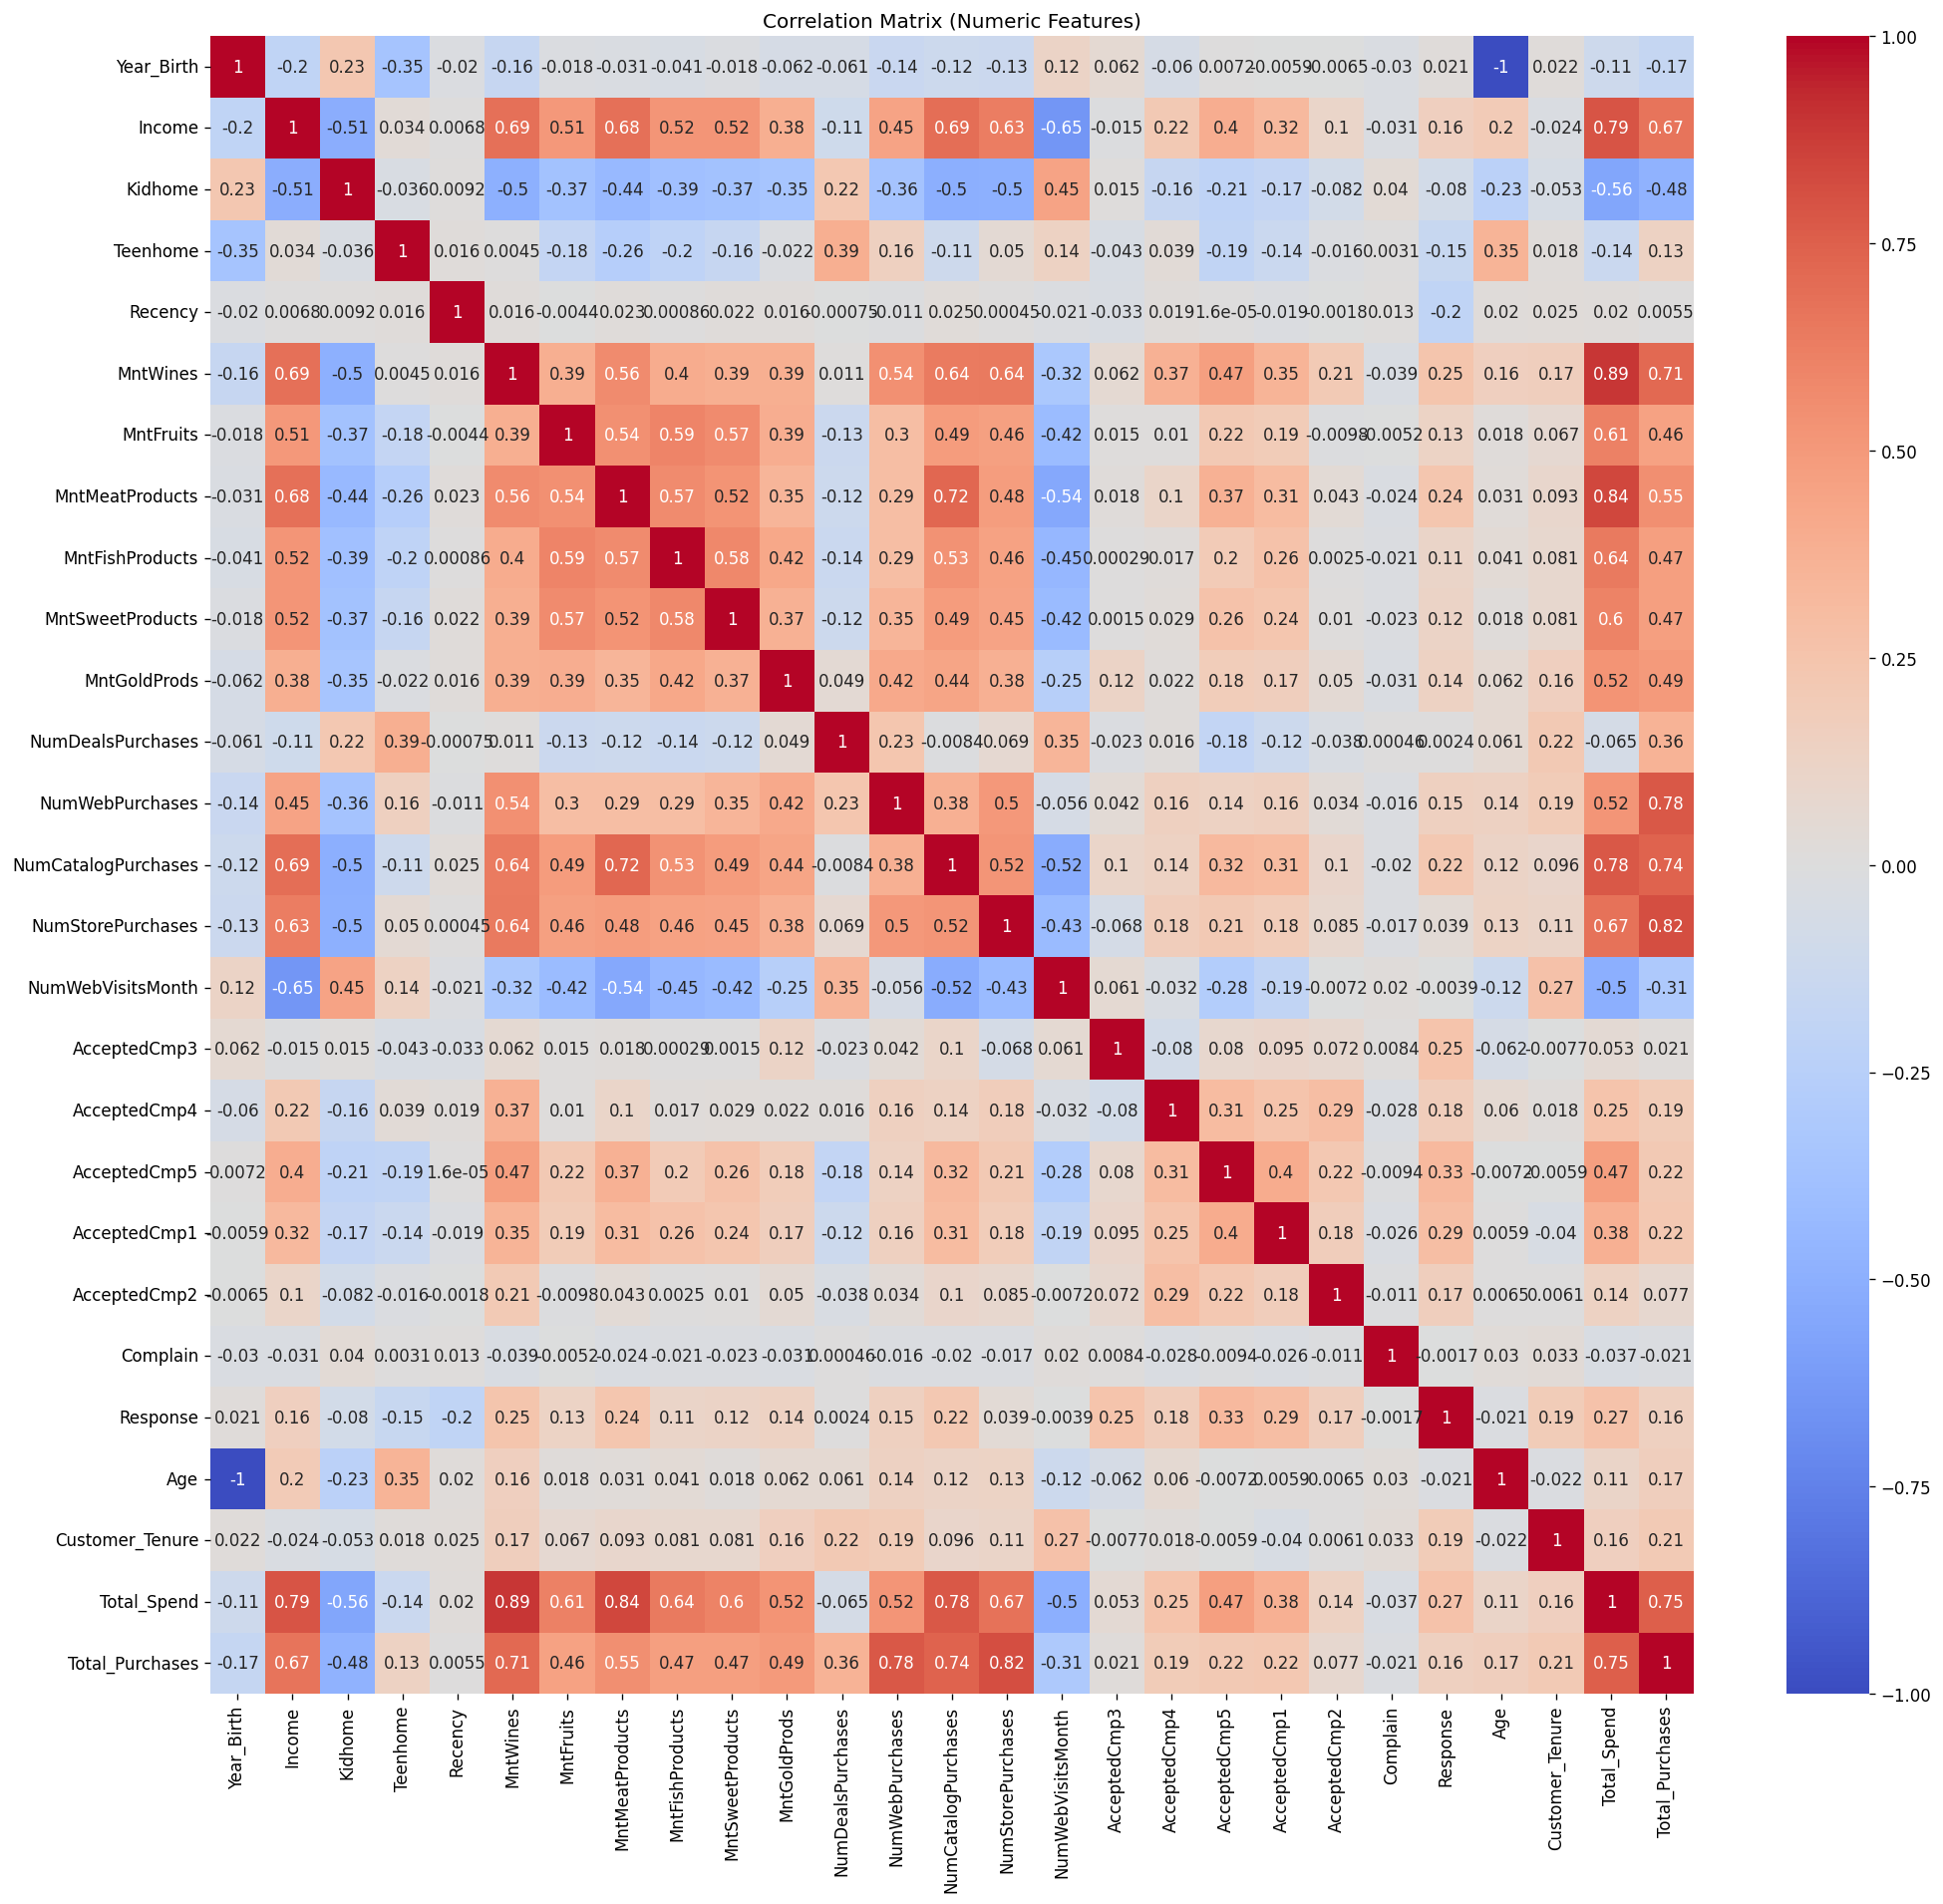

In [34]:
# Correlation matrix for numeric features
numeric_features_all = df.select_dtypes(include=["int64","float64"]).columns.tolist()
plt.figure(figsize=(20, 18), dpi=120) 
sns.heatmap(df[numeric_features_all].corr(), cmap="coolwarm", center=0, annot=True)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

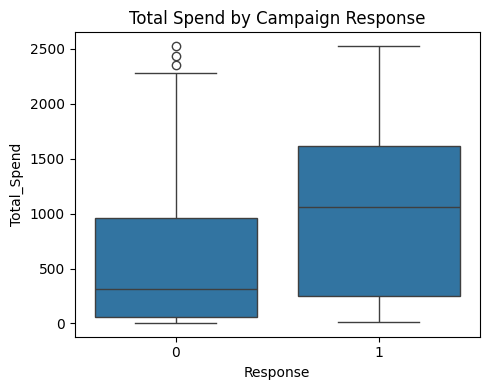

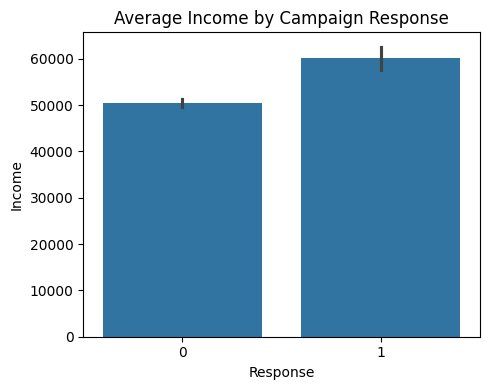

In [39]:
# Plot how spend and imcome features relate to the Response variable
plt.figure(figsize=(5,4))
sns.boxplot(x="Response", y="Total_Spend", data=df)
plt.title("Total Spend by Campaign Response")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
sns.barplot(x="Response", y="Income", data=df, estimator=np.mean)
plt.title("Average Income by Campaign Response")
plt.tight_layout()
plt.show()

#### 4B) Analysis and Conclusion
- Many numeric variables (Income, Total_Spend, Total_Purchases) are right-skewed, indicating the presence of high-value customers. This justifies using standardization and considering methods that are robust to scale differences.
- Strong correlations among spending and purchase-related features indicate multicollinearity, which motivates applying PCA to capture the main axes of variation while reducing redundancy. This is important for clustering methods like KMeans and Agglomerative clustering.
- The relationship between features and the Response variable is present but not extremely strong. High-spend and high-purchase customers tend to respond more, but there is substantial overlap.
- Create aggregate features such as Total_Spend, Total_Purchases, and Customer_Tenure will summarize behavior and improve interpretability of cluster profiles.

### 5) Processing and modeling

I drop the target feature "Response", use StandardScaler for scaling numeric features and apply OneHotEncoder to transform all categorical features. Since PCA and clustering algorithms require dense arrays, I converts the resulting sparse matrix to a dense NumPy array. Then, I prints out the shape of the fully preprocessed dataset, ready for PCA or unsupervised learning.

Next, I use PCA for reducing dimension, then ierate to find the best k and use Kmeans and Agglomerative Clustering Algorithms to train the data and record the scores. Finally, I find important features using RandomForestClassifier.

#### 5.1)Prepare data for unsupervised models

In [40]:
target_col = "Response"      # for later supervised step

X = df.drop(columns=[target_col])
y_response = df[target_col]  # keep for later

numeric_features = X.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object","category"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)



Numeric features: ['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Age', 'Customer_Tenure', 'Total_Spend', 'Total_Purchases']
Categorical features: ['Education', 'Marital_Status']


#### 5.2) Preprocessing: scale numeric, one-hot encode categorical

In [41]:
preprocess_unsup = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

X_prepared = preprocess_unsup.fit_transform(X)

# Convert to dense for PCA / clustering
if hasattr(X_prepared, "toarray"):
    X_dense = X_prepared.toarray()
else:
    X_dense = X_prepared

print("Shape after preprocessing:", X_dense.shape)

Shape after preprocessing: (2239, 39)


#### 5.3) PCA-Dimension reduction and loading

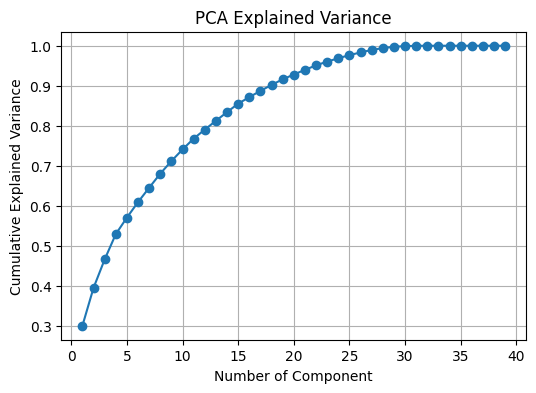

Components for ~90% variance: 18
Shape after PCA: (2239, 18)


In [44]:
# Fit full PCA to inspect explained variance
pca_full=PCA()
pca_full.fit(X_dense)
cum_var=np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(range(1,len(cum_var)+1), cum_var, marker="o")
plt.xlabel("Number of Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

# Choose number of components to explain ~90% variance
n_components=np.argmax(cum_var>=0.90)+1
print("Components for ~90% variance:", n_components)

pca_reduced=PCA(n_components=n_components, random_state=42)
X_pca=pca_reduced.fit_transform(X_dense)
print("Shape after PCA:", X_pca.shape)

In [48]:
# Get feature names after preprocessing and loading
ohe = preprocess_unsup.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

loadings = pd.DataFrame(
    pca_reduced.components_.T,
    index=all_feature_names,
    columns=[f"PC{i+1}" for i in range(n_components)]
)

print("Top 10 contributors to PC1:")
print(loadings["PC1"].abs().sort_values(ascending=False).head(10))

Top 10 contributors to PC1:
Total_Spend            0.332579
Income                 0.296703
Total_Purchases        0.289892
NumCatalogPurchases    0.286981
MntWines               0.284084
MntMeatProducts        0.276343
NumStorePurchases      0.264508
MntFishProducts        0.240105
MntSweetProducts       0.233140
MntFruits              0.231166
Name: PC1, dtype: float64


#### 5.4) KMeans Clusters and hyperparameter search k

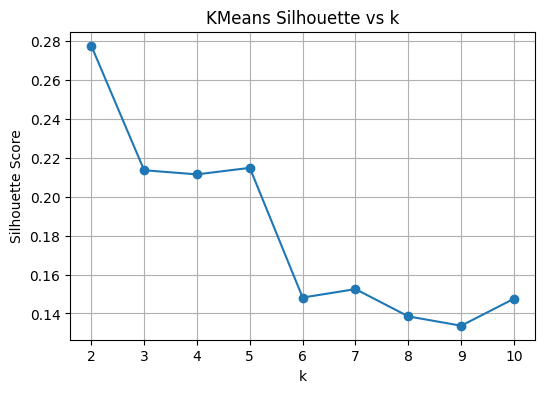

Best k for KMeans (by silhouette): 2
KMeans – Silhouette: 0.2775493005367181
KMeans – Davies-Bouldin: 1.5624323566643863
KMeans cluster sizes:
Cluster_KMeans
0    1279
1     960
Name: count, dtype: int64


In [50]:
from sklearn.metrics import calinski_harabasz_score
# Iterate k to find k with the best score
k_values = range(2, 11)
sil_scores_km = []
ch_scores_km = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = km.fit_predict(X_pca)
    sil_scores_km.append(silhouette_score(X_pca, labels_k))

# Plot k with Silhouette Score
plt.figure(figsize=(6,4))
plt.plot(k_values, sil_scores_km, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("KMeans Silhouette vs k")
plt.grid(True)
plt.show()

# Identify the best k
best_k_kmeans = k_values[int(np.argmax(sil_scores_km))]
print("Best k for KMeans (by silhouette):", best_k_kmeans)

# Use the best k for KMeans
kmeans_final = KMeans(n_clusters=best_k_kmeans, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(X_pca)

df["Cluster_KMeans"] = labels_kmeans

# Use two metrics to record the score
sil_kmeans = silhouette_score(X_pca, labels_kmeans)
db_kmeans = davies_bouldin_score(X_pca, labels_kmeans)

print("KMeans – Silhouette:", sil_kmeans)
print("KMeans – Davies-Bouldin:", db_kmeans)
print("KMeans cluster sizes:")
print(df["Cluster_KMeans"].value_counts().sort_index())

#### 5.5) Agglomerative Clustering (same k)

In [51]:
agg = AgglomerativeClustering(n_clusters=best_k_kmeans, linkage="ward")
labels_agg = agg.fit_predict(X_pca)

df["Cluster_Agg"] = labels_agg

sil_agg = silhouette_score(X_pca, labels_agg)
db_agg = davies_bouldin_score(X_pca, labels_agg)

print("Agglomerative – Silhouette:", sil_agg)
print("Agglomerative – Davies-Bouldin:", db_agg)
print("Agglomerative cluster sizes:")
print(df["Cluster_Agg"].value_counts().sort_index())

Agglomerative – Silhouette: 0.24177297353533803
Agglomerative – Davies-Bouldin: 1.606045693219971
Agglomerative cluster sizes:
Cluster_Agg
0    1147
1    1092
Name: count, dtype: int64


#### 5.6) Feature importance for Clusters using RandomForestClassifier
I train RF to predict KMeans clusters from original features -> feature importances will tell which features define clusters.

Top 15 features explaining KMeans clusters:
                Feature  Importance
24          Total_Spend    0.258092
13  NumCatalogPurchases    0.129028
7       MntMeatProducts    0.118839
1                Income    0.109742
5              MntWines    0.100496
25      Total_Purchases    0.051878
14    NumStorePurchases    0.045542
9      MntSweetProducts    0.035995
6             MntFruits    0.032756
8       MntFishProducts    0.023896
12      NumWebPurchases    0.017342
2               Kidhome    0.016485
15    NumWebVisitsMonth    0.014663
10         MntGoldProds    0.012303
11    NumDealsPurchases    0.004498


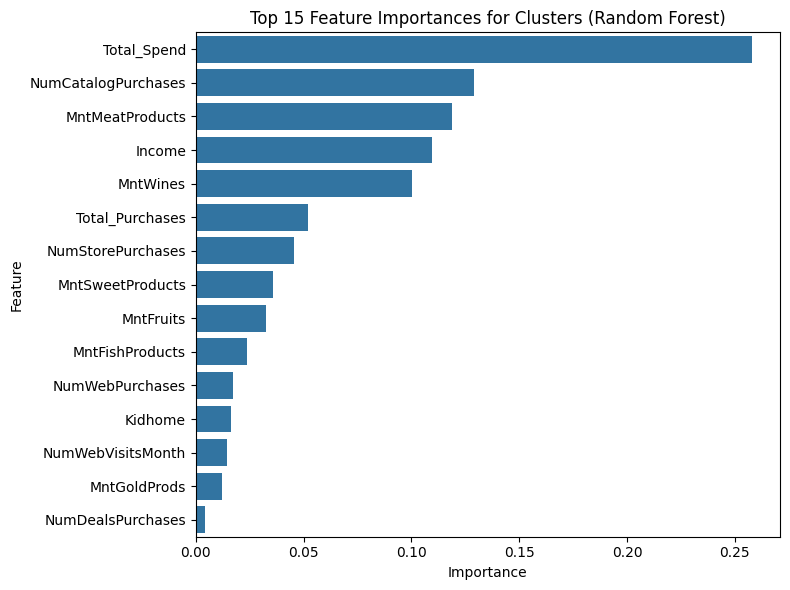

In [53]:
X_for_clf = X.copy()
y_clusters = df["Cluster_KMeans"]

preprocess_clf = ColumnTransformer(transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)])

X_clf = preprocess_clf.fit_transform(X_for_clf)

rf_clf = RandomForestClassifier(n_estimators=300,random_state=42,class_weight="balanced")
rf_clf.fit(X_clf, y_clusters)

# Get feature names after encoding
ohe_clf = preprocess_clf.named_transformers_["cat"]
cat_feature_names_clf = ohe_clf.get_feature_names_out(categorical_features)
all_feature_names_clf = np.concatenate([numeric_features, cat_feature_names_clf])

feat_importance = pd.DataFrame({"Feature": all_feature_names_clf,
        "Importance": rf_clf.feature_importances_}).sort_values("Importance", ascending=False)

print("Top 15 features explaining KMeans clusters:")
print(feat_importance.head(15))

plt.figure(figsize=(8,6))
sns.barplot(data=feat_importance.head(15), x="Importance", y="Feature")
plt.title("Top 15 Feature Importances for Clusters (Random Forest)")
plt.tight_layout()
plt.show()

### 6) Results and analysis
#### Results in tables and visualizations

In [56]:
model_metrics = pd.DataFrame([
    ["KMeans", best_k_kmeans, sil_kmeans, db_kmeans],
    ["Agglomerative", best_k_kmeans, sil_agg, db_agg],
], columns=["Model","k","Silhouette_Score","Davies_Bouldin_Score"])

print("Model metric summary:")
print(model_metrics)

Model metric summary:
           Model  k  Silhouette_Score  Davies_Bouldin_Score
0         KMeans  2          0.277549              1.562432
1  Agglomerative  2          0.241773              1.606046


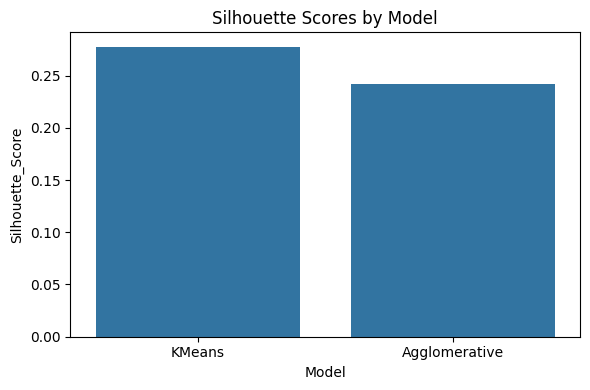

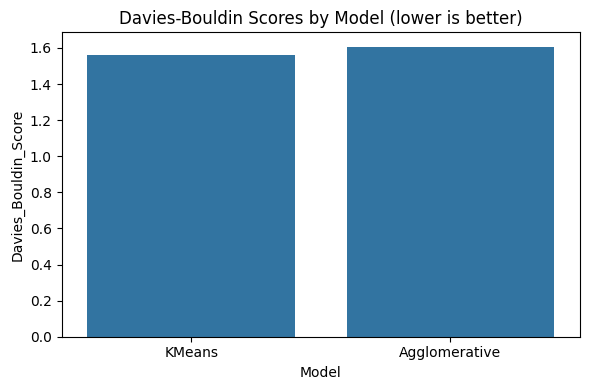

In [57]:
# Bar plot of silhouette scores
plt.figure(figsize=(6,4))
sns.barplot(data=model_metrics, x="Model", y="Silhouette_Score")
plt.title("Silhouette Scores by Model")
plt.tight_layout()
plt.show()

# Bar plot of Davies-Bouldin scores
plt.figure(figsize=(6,4))
sns.barplot(data=model_metrics, x="Model", y="Davies_Bouldin_Score")
plt.title("Davies-Bouldin Scores by Model (lower is better)")
plt.tight_layout()
plt.show()

In [58]:
# Cluster size tables
cluster_sizes=pd.DataFrame({"KMeans": df["Cluster_KMeans"].value_counts().sort_index(),
                            "Agglomerative": df["Cluster_Agg"].value_counts().sort_index()})
print("Cluster Sizes by Model")
print(cluster_sizes)

Cluster Sizes by Model
   KMeans  Agglomerative
0    1279           1147
1     960           1092


In [59]:
# Cluster profiles for each model (means of numeric features and target_col)
cluster_profile_kmeans=df.groupby("Cluster_KMeans")[numeric_features+[target_col]].mean().round(2)
cluster_profile_agg=df.groupby("Cluster_Agg")[numeric_features+[target_col]].mean().round(2)

print("KMeans Cluster Profile")
print(cluster_profile_kmeans)

print("\n Agglomerative Cluster Profile")
print(cluster_profile_agg)
                             

KMeans Cluster Profile
                Year_Birth    Income  Kidhome  Teenhome  Recency  MntWines  \
Cluster_KMeans                                                               
0                  1970.43  38096.53     0.71      0.54    48.88     83.06   
1                  1966.64  70438.47     0.09      0.47    49.44    598.52   

                MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
Cluster_KMeans                                                                  
0                    6.41            33.92             9.49              6.18   
1                   52.82           344.34            74.91             54.91   

                ...  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
Cluster_KMeans  ...                                                           
0               ...          0.03          0.00          0.01          0.00   
1               ...          0.14          0.17          0.14          0.03   

                Compla

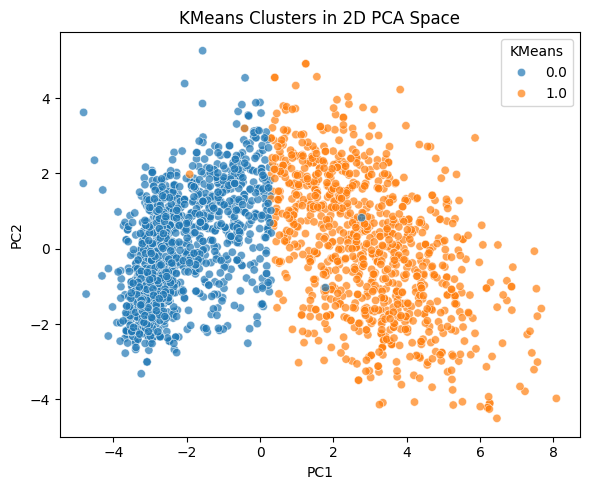

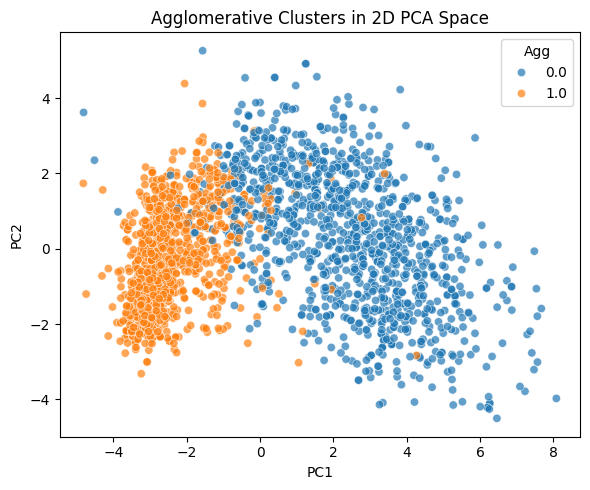

In [63]:
# # PCA scatter plots colored by clusters
pca_2 = PCA(n_components=2, random_state=42)
X_pca2 = pca_2.fit_transform(X_dense)
pca2_df = pd.DataFrame(X_pca2, columns=["PC1","PC2"])
pca2_df["KMeans"] = df["Cluster_KMeans"]
pca2_df["Agg"]    = df["Cluster_Agg"]

plt.figure(figsize=(6,5))
sns.scatterplot(data=pca2_df, x="PC1", y="PC2", hue="KMeans", palette="tab10", alpha=0.7)
plt.title("KMeans Clusters in 2D PCA Space")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(data=pca2_df, x="PC1", y="PC2", hue="Agg", palette="tab10", alpha=0.7)
plt.title("Agglomerative Clusters in 2D PCA Space")
plt.tight_layout()

#### Compare the results and discuss model performance
To compare the two clustering methods, I evaluated them using Silhouette Score and Davies–Bouldin Score. Both metrics are computed on the PCA-transformed feature space with k = 2 clusters. Both methods achieve moderate Silhouette scores (~0.24–0.28), which suggests that there is some cluster structure in the data, but not perfectly clean separation. KMeans outperforms Agglomerative on both metrics: Slightly higher Silhouette (0.2775 vs 0.2418) and Slightly lower DB (1.56 vs 1.61).

KMeans creates a mildly imbalanced split (about 57% vs 43% of customers). Agglomerative produces a more balanced partition (roughly 51% vs 49%). Both partitions are reasonable. The slight imbalance in KMeans is acceptable and may reflect a real difference between a larger customer group and a smaller, more distinct segment.

In the KMeans plot, the two clusters form an almost diagonal separation: One cluster occupies mostly the left side and the other cluster occupies the right side. There is some overlap in the middle, but the boundary between the two segments is visually clear. 

In the Agglomerative plot, one cluster is concentrated more strongly on the far left, while the other spreads across a larger region to the right. The overlap between orange and blue points is more noticeable, especially in the central region of the plot. This is consistent with the slightly lower Silhouette score: the clusters are less cleanly separated in the PCA space.

Overall, the PCA scatterplots support the numerical metrics: both models find a meaningful 2-way segmentation, but KMeans yields cleaner visual separation.

#### Map clusters to majority label to predict and compare to a supervised learning method
In addition to clustering, I want to evaluate the extent to which the unsupervised models can approximate label prediction by aligning clusters with the majority class within each group. This performance is then compared against a supervised model to highlight differences in predictive accuracy.


In [62]:
from sklearn.metrics import accuracy_score

# Train KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

df["Cluster"] = clusters

# Map cluster → majority label
cluster_to_label = (
    df.groupby("Cluster")["Response"].agg(lambda x: x.value_counts().index[0]).to_dict())

print("Cluster-to-label mapping:", cluster_to_label)

# Predicted labels
df["Cluster_Pred"] = df["Cluster"].map(cluster_to_label)

# Accuracy
acc = accuracy_score(df["Response"], df["Cluster_Pred"])
print("Unsupervised prediction accuracy:", acc)

Cluster-to-label mapping: {0: 0, 1: 0}
Unsupervised prediction accuracy: 0.8508262617239839


In [68]:
# Train on a supervised learning method
X_base = df.drop(columns=[target_col, "Cluster_KMeans", "Cluster_Agg"])
y = df[target_col]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_base, y, test_size=0.2, random_state=42, stratify=y)

num_b = X_base.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_b = X_base.select_dtypes(include=["object","category"]).columns.tolist()

preprocess_b = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_b),
                  ("cat", OneHotEncoder(handle_unknown="ignore"), cat_b)])

rf_base = Pipeline(steps=[("prep", preprocess_b),
                          ("clf", RandomForestClassifier(n_estimators=300, random_state=42))])

rf_base.fit(X_train_b, y_train_b)
y_pred_b = rf_base.predict(X_test_b)
acc_base = accuracy_score(y_test_b, y_pred_b)
print("Supervised Learning Method:", acc_base)

Supervised Learning Method: 0.8883928571428571


The cluster-to-label mapping {0: 0, 1: 0} indicates that both clusters are dominated by customers with Response = 0. This means the dataset is heavily imbalanced in Response feature, with non-responders forming the majority in both behavioral segments. Although clustering successfully identifies meaningful customer groups, the true campaign responders (label = 1) are too few and too mixed across the dataset to form their own cluster. Therefore, clustering cannot reliably separate responders based solely on the available features. This also explains why the unsupervised model predicts label 0 for all customers after majority-label mapping.

### 7) Discussion and conclusion
This project demonstrates that unsupervised learning is highly effective for discovering meaningful customer segments, but these segments do not fully explain campaign response behavior. 

KMeans outperformed Agglomerative clustering both numerically and visually, indicating that the structure of the dataset aligns more naturally with the assumptions of KMeans.

Although the clusters aligned moderately with the response variable (85% unsupervised accuracy), the dataset’s strong imbalance meant that both clusters were dominated by non-responders. Supervised learning (Random Forest) ultimately provided better predictive performance (89%) because supervised models directly optimize for the target label, learn subtle interactions between features, and use minority-class patterns better than clustering.

This project reveals several important limitations. First, there is a strong class imbalance in 'Response' feature because most customers do not respond. This causes both clusters to be dominated by label 0, removing the possibility of forming a “responder” cluster. Second, clusters reflect socio-economic and behavioral segmentation, not campaign outcome; therefore, clustering is excellent for marketing insights, but not for direct prediction of campaign success. Finally, PCA keeps components with the highest variance, not necessarily the ones related to Response. Thus, some fine-grained predictive information may be lost in dimensionality reduction.

Overall, clustering remains valuable for customer profiling, understanding purchasing patterns, and designing tailored marketing strategies, while supervised models remain the preferred choice for predicting campaign outcomes. 

### Github repository URL
https://github.com/phi-nguyen-95/Discovering-customer-behavioral-patterns
